## https://androidkt.com/use-saved-pytorch-model-to-predict-single-and-multiple-images/

In [ ]:
import torch
import torch.nn.functional as F
import torchvision

from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

import time
import os
import copy
import io

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [ ]:
os.environ['KAGGLE_USERNAME'] = "brijesh123" 
os.environ['KAGGLE_KEY'] = "d9bf8ffaccf13619cf2ea0f84956fc96" 

In [ ]:
!kaggle competitions download -c dog-breed-identification

 97% 668M/691M [00:04<00:00, 224MB/s]
100% 691M/691M [00:04<00:00, 169MB/s]


In [ ]:
!unzip dog-breed-identification.zip

In [ ]:
label_df = pd.read_csv('/content/labels.csv')

print('Training set: {}'.format(label_df.shape))

Training set: (10222, 2)


In [ ]:
label_df.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [ ]:
# Encode the breed into digits
label_df['label'] = LabelEncoder().fit_transform(label_df.breed)

# Create a breed-2-index dictionary
dict_df = label_df[['label','breed']].copy()
dict_df.drop_duplicates(inplace=True)
dict_df.set_index('label',drop=True,inplace=True)

index_to_breed = dict_df.to_dict()['breed']

In [ ]:
train_dir='/content/train'

label_df.id = label_df.id.apply(lambda x: x+'.jpg')
label_df.id = label_df.id.apply(lambda x:train_dir+'/'+x)

# Drop the breed column
label_df.pop('breed')

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [ ]:
class DogDataset(Dataset):
    def __init__(self,dataframe,transform=None,test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.test = test
        
    def __getitem__(self,index):
        x = Image.open(self.dataframe.iloc[index,0])
        if self.transform:
            x = self.transform(x)
        if self.test:
            return x
        else:
            y = self.dataframe.iloc[index,1]
            return x,y
        
    def __len__(self):
        return self.dataframe.shape[0]

In [ ]:
# Creat transfomers
train_transformer = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.RandomRotation(15),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transformer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
batch_size = 64

train_df,test_df=train_test_split(label_df, test_size=0.1, random_state=0)

train_df.shape,test_df.shape

# Create dataloaders form datasets
train_set = DogDataset(train_df, transform=train_transformer)
val_set = DogDataset(test_df, transform=val_transformer)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set , batch_size=batch_size, shuffle=True)

dataset_sizes=len(train_set)

print(dataset_sizes,len(val_set))

9199 1023


In [ ]:
# Get a batch of training data
inputs, classes = next(iter(val_loader))
classes=classes.numpy()

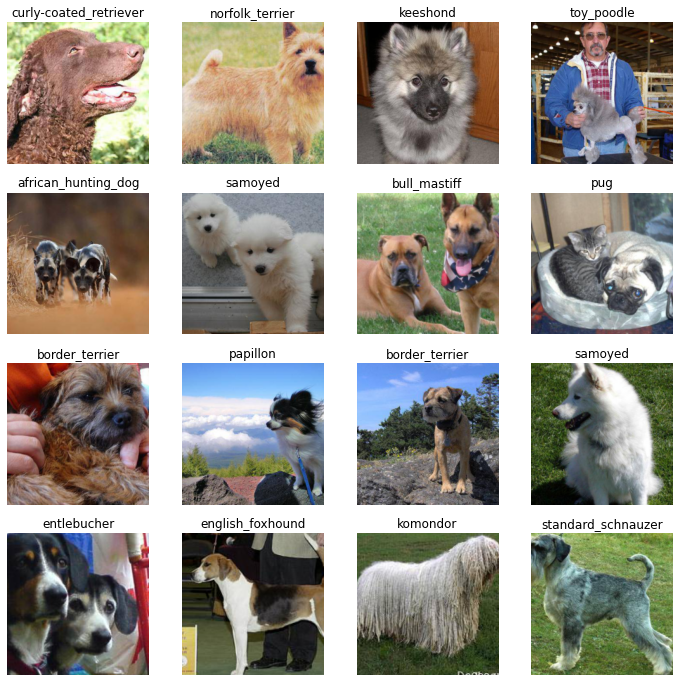

In [ ]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(val_set), size=(1,)).item()
    
    inp = inputs[i-1].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    figure.add_subplot(rows, cols, i)
    plt.title(index_to_breed[classes[i-1]])
    plt.axis("off")
    plt.imshow(inp)
plt.show()

In [ ]:
# Use resnet-50 as a base model
class Model(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(Model,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

resNet = torchvision.models.resnet50(pretrained=True)

In [ ]:
# Setting up gpu
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

for param in resNet.parameters():
    param.requires_grad=False

model = Model(base_model=resNet, base_out_features=resNet.fc.out_features, num_classes=120)
model = model.to(device)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode    
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        scheduler.step()

        epoch_loss = running_loss / dataset_sizes
        epoch_acc = running_corrects.double() / dataset_sizes

        print(f' Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [ ]:
# Cost function and optimzier
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr=0.0003)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, loss_function, optimizer,scheduler,num_epochs=20)

Epoch 0/19
----------
 Training Loss: 2.8594 Acc: 0.3857

Epoch 1/19
----------
 Training Loss: 1.5148 Acc: 0.6142

Epoch 2/19
----------
 Training Loss: 1.3449 Acc: 0.6376

Epoch 3/19
----------
 Training Loss: 1.2635 Acc: 0.6626

Epoch 4/19
----------
 Training Loss: 1.2110 Acc: 0.6734

Epoch 5/19
----------
 Training Loss: 1.1786 Acc: 0.6891

Epoch 6/19
----------
 Training Loss: 1.1560 Acc: 0.6891

Epoch 7/19
----------
 Training Loss: 1.0386 Acc: 0.7187

Epoch 8/19
----------
 Training Loss: 1.0228 Acc: 0.7269

Epoch 9/19
----------
 Training Loss: 1.0374 Acc: 0.7223

Epoch 10/19
----------
 Training Loss: 1.0179 Acc: 0.7265

Epoch 11/19
----------
 Training Loss: 1.0182 Acc: 0.7267

Epoch 12/19
----------
 Training Loss: 1.0109 Acc: 0.7248

Epoch 13/19
----------
 Training Loss: 1.0132 Acc: 0.7271

Epoch 14/19
----------
 Training Loss: 0.9987 Acc: 0.7326

Epoch 15/19
----------
 Training Loss: 0.9974 Acc: 0.7288

Epoch 16/19
----------
 Training Loss: 0.9866 Acc: 0.7299

Epoch 1

In [ ]:
# Specify a path
PATH = "entire_model.pt"
# Save
torch.save(model, PATH)

# Load
model = torch.load(PATH)
model.eval()


In [ ]:
inputs, classes = next(iter(val_loader))

model = model.to(device)
inputs=inputs.to(device)

outputs=model(inputs)
_, preds = torch.max(outputs, 1)
preds=preds.cpu().numpy()
classes=classes.numpy()
print(preds)
print(classes)

[ 56  48 101  10   6  96  37 101  39  38 118   3 117  23  69   5  61  61
  70  28 101  55  87  31  62  64  34  63  74  98  82  81  87  77  96  95
 102  37  85  71  54  37  27  84  39  75  23  65  88  35 119   5  16  16
  49  64  64 101  75  36  22  52  52   6]
[ 56  48  43  10   6  96  37 101 113   5 118   3 117  23  69   5  61  61
 100  28 101  55  87  31  62  64  34  63  74 103  82  81  87  77  96  54
 102  37  85  71  54  37  27  84   9  75  23  65  88  35 102  11  33  33
  49  64  64 101  63  36  22  66  52  79]


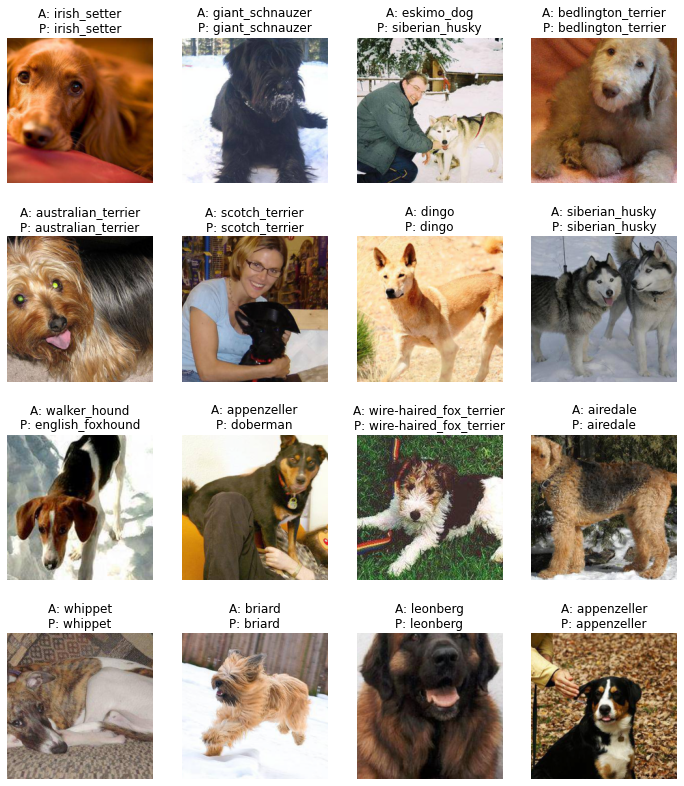

In [ ]:
figure = plt.figure(figsize=(12, 14))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(val_set), size=(1,)).item()
    
    inp = inputs.cpu()[i-1].numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    figure.add_subplot(rows, cols, i)
    plt.title('A: '+index_to_breed[classes[i-1]]+'\nP: '+index_to_breed[preds[i-1]])
    plt.axis("off")
    plt.imshow(inp)

plt.show()

In [ ]:
def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)

english_foxhound  at confidence score:0.89


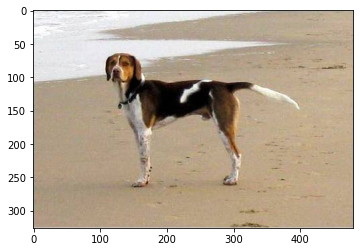

In [ ]:
model = torch.load(PATH)
model.eval()

def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor=tensor.to(device)
    output = model.forward(tensor)
    
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), index_to_breed[classes.item()]

image_path="/content/test/06b3a4da7b96404349e51551bf611551.jpg"
image = plt.imread(image_path)
plt.imshow(image)

with open(image_path, 'rb') as f:
    image_bytes = f.read()

    conf,y_pre=get_prediction(image_bytes=image_bytes)
    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))

